Seul le dataset Franklin Roosevelt est actuellement géré. A faire : ajouter les autres stations et faire des comparaisons / les coupler

## **Load and clean dataset**

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt

def load_and_clean_df_air():
    # --Voir notebook 'explore_df_air' pour des explications sur ce qui est fait en terme de nettoyage
    
    df_air=pd.read_csv('data/1.a. qualite-de-lair-mesuree-dans-la-station-franklin-d-roosevelt.csv',delimiter=';')
    
    # Conversion de la donnée temporelle en objet datetime
    df_air['date/heure']=df_air['date/heure'].str.extract('([^+]*)')
    df_air['date/heure']=pd.to_datetime(df_air['date/heure'])
    
    # Nettoyage des données numériques
    df_air=df_air.replace('ND',np.nan)
    df_air[['NO','PM10']]=df_air[['NO','PM10']].applymap(lambda x : re.search('(\d+)',x).group(1)  if pd.notnull(x) else np.nan)
    df_air[['TEMP','HUMI']]=df_air[['TEMP','HUMI']].applymap(lambda x : x.replace(',','.') if pd.notnull(x) else np.nan)
    df_air[df_air.columns[1:]]=df_air[df_air.columns[1:]].astype(float)
    
    # Complétion de la série temporelle et passage en index
    df_air=df_air.groupby('date/heure').mean()
    full_index = pd.date_range(start=df_air.index[0], end=df_air.index[-1], freq='H')
    df_air=df_air.reindex(full_index)
    
    # Interpolation pour "sauver" les lignes qui peuvent l'être
    df_air=df_air.sort_index()
    df_air=df_air.interpolate(limit=2) # On interpole jusqu'à 2 NaN consécutif. Au dela, on laisse les NaN
    # Rq : interpolate et limit fonctionnent tel que si on a un trou de 10 valeurs, il va interpoler le 2 premières en se basant sur la précédente et la onzième
    
    # Suppression des lignes contenant des NaN et mise au format définitif
    df_air=df_air.dropna()
    df_air[['NO','NO2','PM10','CO2']]=df_air[['NO','NO2','PM10','CO2']].astype(int)
    
    # Passage du CO2 à droite pour pouvoir l'isoler plus facilement (autre échelle)
    df_air[['NO','NO2','PM10','CO2','TEMP','HUMI']]=df_air[['NO','NO2','PM10','TEMP','HUMI','CO2']]
    
    return df_air
    
    

In [2]:
df_air=load_and_clean_df_air()
df_air

,NO,NO2,PM10,CO2,TEMP,HUMI
2013-01-01 02:00:00,23,41,26,15.1,65.6,612
2013-01-01 03:00:00,43,61,18,14.9,65.0,536
2013-01-01 04:00:00,22,52,45,14.9,63.3,490
2013-01-01 05:00:00,27,56,22,14.9,63.7,481
2013-01-01 06:00:00,27,57,15,15.0,63.3,464
...,...,...,...,...,...,...
2021-10-17 22:00:00,5,37,50,19.9,39.6,551
2021-10-17 23:00:00,7,40,48,20.2,40.8,532
2021-10-18 00:00:00,6,44,42,20.7,40.5,522
2021-10-18 01:00:00,7,46,35,20.5,40.6,512


In [3]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64394 entries, 2013-01-01 02:00:00 to 2021-10-18 02:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NO      64394 non-null  int64  
 1   NO2     64394 non-null  int64  
 2   PM10    64394 non-null  int64  
 3   CO2     64394 non-null  float64
 4   TEMP    64394 non-null  float64
 5   HUMI    64394 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 3.4 MB


## **FIRST GRAPHS**

In [38]:
def display_graphs(data):
    
    fig=plt.figure(figsize=[13,4])
    plot_not_norm(fig,data)
    plot_norm(fig,data)
        
    return fig


def plot_not_norm(fig,data):

    ax1=fig.add_axes([0,0,0.46,0.85])
    c1=ax1.plot(data[df_air.columns[0:5]]);

    ax2 = ax1.twinx()
    c2=ax2.plot(data[data.columns[5]],'k');

    ax1.legend(c1+c2,data.columns[0:6],loc='best');
    plt.xticks(ticks=data.index.unique().sort_values());
    
    ax1.set_title('Données non normalisées - CO2 sur axe de droite')
    
    return fig


def plot_norm(fig,data):
    
    data=data/data.mean()

    ax1=fig.add_axes([0.54,0,0.46,0.85])
    c1=ax1.plot(data[df_air.columns[0:6]]);
    c1[5].set_color('k')

    plt.xticks(ticks=data.index.unique().sort_values());
    plt.legend(c1,data.columns[0:6],loc='best');
    
    ax1.set_title('Données normalisées')
    
    return fig

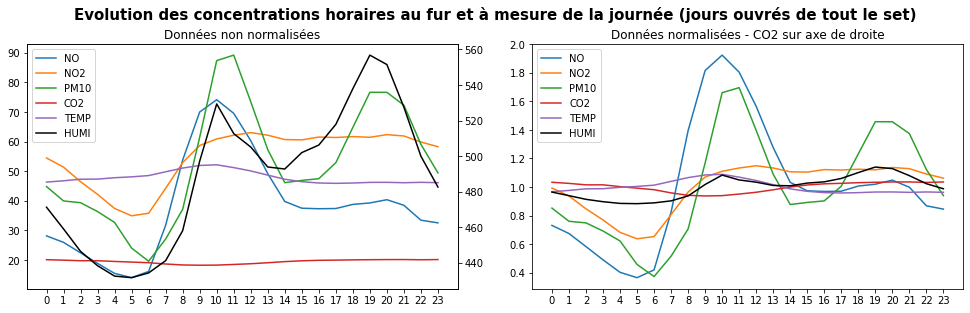

In [39]:
data=df_air.loc[df_air.index.weekday<=4].groupby(df_air.loc[df_air.index.weekday<=4].index.hour).mean()
fig=display_graphs(data)
fig.suptitle('Evolution des concentrations horaires au fur et à mesure de la journée (jours ouvrés de tout le set)',fontweight='bold',fontsize=15);

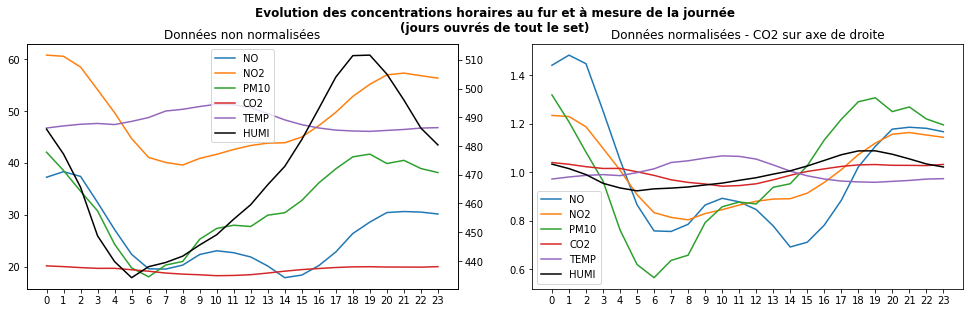

In [43]:
data=df_air.loc[df_air.index.weekday>4].groupby(df_air.loc[df_air.index.weekday>4].index.hour).mean()
fig=display_graphs(data)
fig.suptitle('Evolution des concentrations horaires au fur et à mesure de la journée (jours ouvrés de tout le set)',fontweight='bold',fontsize=15);

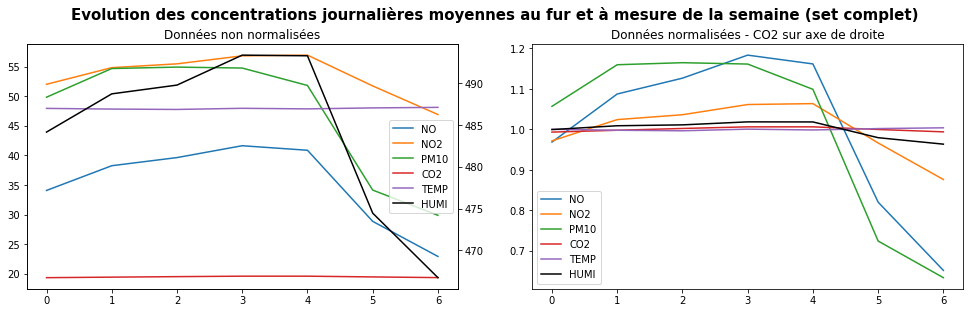

In [45]:
data=df_air.groupby(df_air.index.weekday).mean()
fig=display_graphs(data)
fig.suptitle('Evolution des concentrations journalières moyennes au fur et à mesure de la semaine (set complet)',fontweight='bold',fontsize=15);

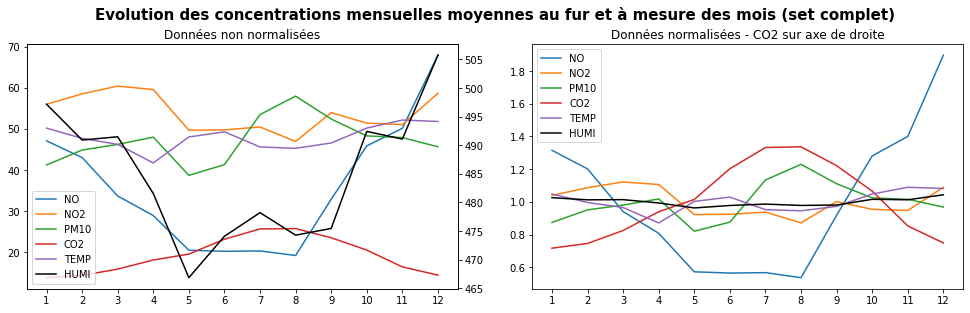

In [47]:
data=df_air.groupby(df_air.index.month).mean()
fig=display_graphs(data)
fig.suptitle('Evolution des concentrations mensuelles moyennes au fur et à mesure des mois (set complet)',fontweight='bold',fontsize=15);

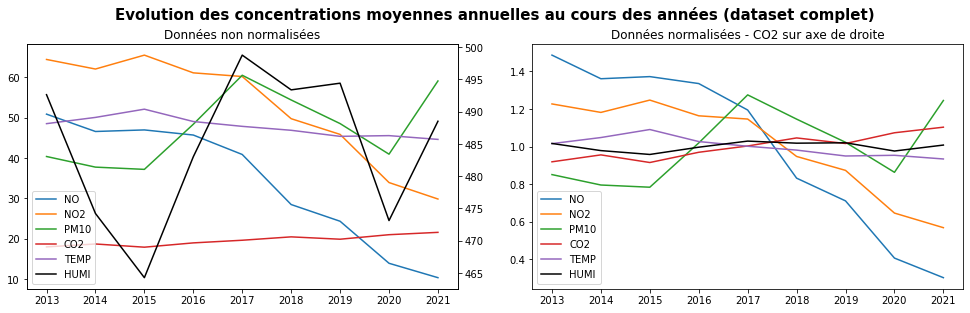

In [49]:
data=df_air.groupby(df_air.index.year).mean()
fig=display_graphs(data)
fig.suptitle('Evolution des concentrations moyennes annuelles au cours des années (dataset complet)',fontweight='bold',fontsize=15);

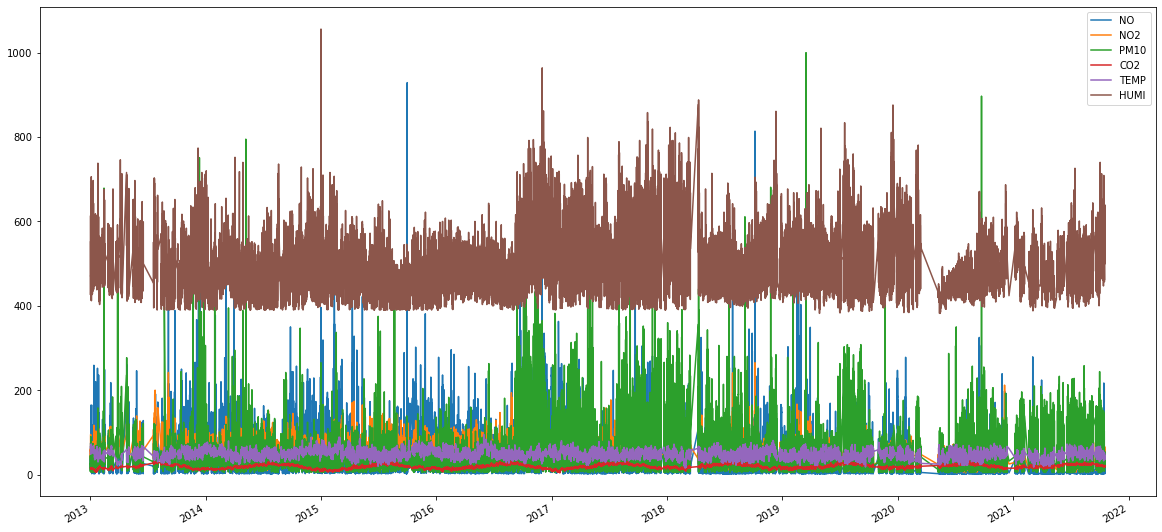

In [50]:
df_air.plot(figsize=[20,10]);